In [1]:
import pandas as pd
import numpy as np

STATS_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Stats.parquet',
}

SCORES_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Scores.parquet',
}

def load_stats(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df['distance'] = df['distance'] / 1000 # convert to km
    df.rename(columns={'modeType': 'counter', 'distance': 'score', 'stat_date': 'ts'}, inplace=True)
    return df[['playerId', 'ts', 'counter', 'score']]

def load_scores(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df.rename(columns={'player_id': 'playerId', 'mobilityScore': 'score', 'day': 'ts'}, inplace=True)
    df['counter'] = 'score'
    return df[['playerId', 'ts', 'counter', 'score']]

df = pd.concat([
    *[load_stats(f, k) for k, f in STATS_FILES.items()], 
    *[load_scores(f, k) for k, f in SCORES_FILES.items()]
])

df['ts'] = pd.to_datetime(df['ts'])
df = df[df['score'] > 0]
df = df.groupby(['playerId', 'counter']).resample('W', on='ts').sum(numeric_only=True).reset_index()
df

,playerId,counter,ts,score
0,u_00144002f1614ee9a45f7822760e3746,score,2023-03-05,15.000000
1,u_00144002f1614ee9a45f7822760e3746,walk,2023-03-05,1.206355
2,u_00567a7bce8c4d09bea7db9bae375af4,bus,2023-03-05,6.484221
3,u_00567a7bce8c4d09bea7db9bae375af4,bus,2023-03-12,0.000000
4,u_00567a7bce8c4d09bea7db9bae375af4,bus,2023-03-19,0.000000
...,...,...,...,...
10668,u_ffe87d71a9ee4521bddf686053b7f8b7,walk,2023-04-30,7.000000
10669,u_ffe87d71a9ee4521bddf686053b7f8b7,walk,2023-05-07,7.985383
10670,u_ffe87d71a9ee4521bddf686053b7f8b7,walk,2023-05-14,2.444950
10671,u_ffe87d71a9ee4521bddf686053b7f8b7,walk,2023-05-21,2.083239


In [2]:
pivoted_df = df.pivot_table(index=['playerId', 'ts'], columns='counter', values='score', fill_value=0)
pivoted_df = pivoted_df.groupby('playerId').filter(lambda x: x.shape[0] > 1)
pivoted_df = pivoted_df.apply(lambda x: x/x.max(), axis=0)

pivoted_df

counter                                        bike       bus  car     score  \
playerId                           ts                                          
u_00567a7bce8c4d09bea7db9bae375af4 2023-03-05   0.0  0.017101  0.0  0.034282   
                                   2023-03-12   0.0  0.000000  0.0  0.078775   
                                   2023-03-19   0.0  0.000000  0.0  0.047411   
                                   2023-03-26   0.0  0.000000  0.0  0.019694   
                                   2023-04-02   0.0  0.022167  0.0  0.056893   
...                                             ...       ...  ...       ...   
u_ffe87d71a9ee4521bddf686053b7f8b7 2023-04-30   0.0  0.000000  0.0  0.045952   
                                   2023-05-07   0.0  0.000000  0.0  0.056163   
                                   2023-05-14   0.0  0.000000  0.0  0.020423   
                                   2023-05-21   0.0  0.000000  0.0  0.016047   
                                   2023-05-28   0.0  0.000000  0.0  0.091904   

counter                                           train      walk  
playerId                           ts                              
u_00567a7bce8c4d09bea7db9bae375af4 2023-03-05  0.000000  0.025855  
                                   2023-03-12  0.000000  0.112664  
                                   2023-03-19  0.066222  0.019916  
                                   2023-03-26  0.000000  0.023970  
                                   2023-04-02  0.000000  0.047140  
...                                                 ...       ...  
u_ffe87d71a9ee4521bddf686053b7f8b7 2023-04-30  0.000000  0.091239  
                                   2023-05-07  0.000000  0.104082  
                                   2023-05-14  0.000000  0.031868  
                                   2023-05-21  0.000000  0.027153  
                                   2023-05-28  0.000000  0.035108  

[3563 rows x 6 columns]

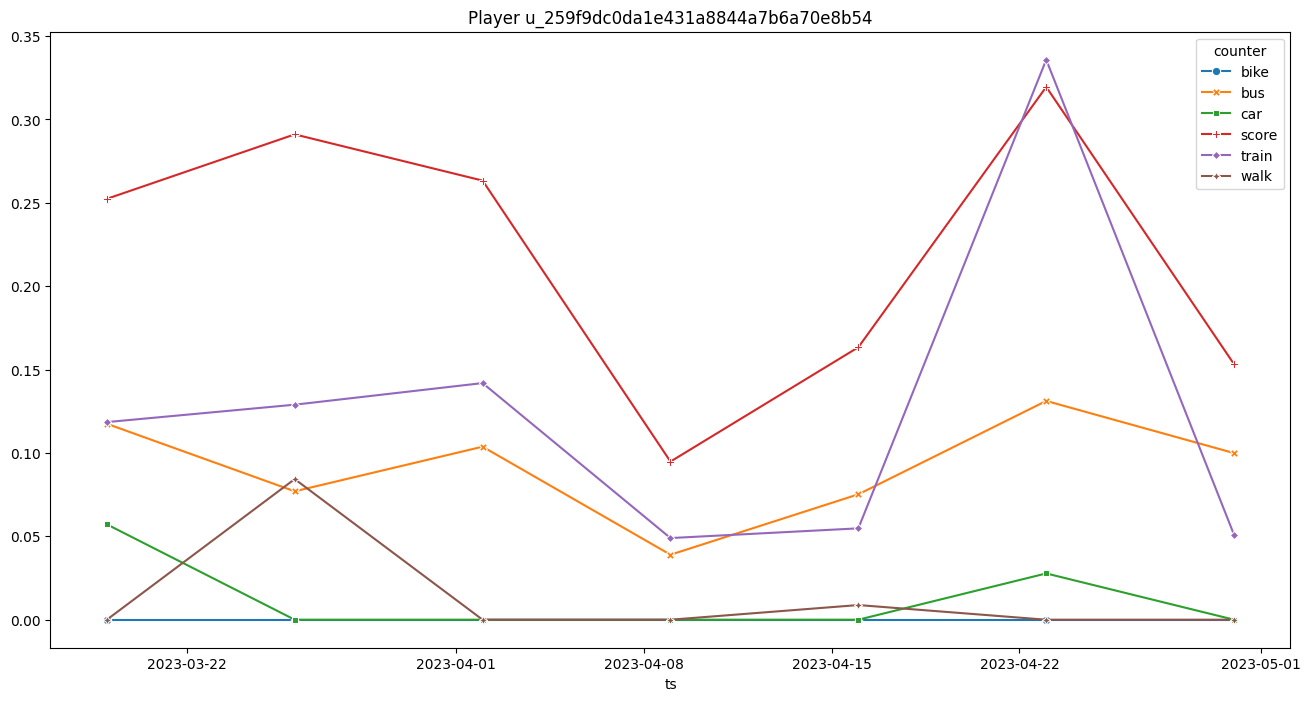

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.random.choice(pivoted_df.index.get_level_values('playerId').unique())
plt.figure(figsize=(16, 8))
sns.lineplot(data=pivoted_df.loc[x], dashes=False, markers=True)
plt.title(f'Player {x}')

plt.show()